<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/LogReg-len64_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pymorphy2 --quiet
!pip install wget --quiet

  Preparing metadata (setup.py) ... done


In [2]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

**Загружаем ощищенные данные**

In [7]:
import wget
import os

PATH_CLEANED_DATASET='data_cleaned_RU_merge_2ch_and_ok.csv'

url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET


if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [8]:

df = pd.read_csv(PATH_CLEANED_DATASET)
df.sample(10)

,comment,toxic
73262,в еле тёплый бежать,0
62607,здравствуйте подсказать пожалуйста вы есть нал...,0
27862,к стенка публично расстрелять да жестоко но др...,1
46829,не согласный где ссср сейчас россия,0
79186,правильно сделать не автобус,0
258430,чтоб обеспечить жизнедеятельность это кусочек ...,0
2622,расстрелять отрава,1
27327,видать не всё хотеть идти,0
107157,зюганов болтун какой мудак за он голосовать эт...,1
22168,да этот молочный кухня быть уникальный не толь...,0


**Взвесим tf-idf**

In [9]:
count_idf_neutral = TfidfVectorizer(min_df=3, max_df=0.8)
count_idf_toxic = TfidfVectorizer(min_df=3, max_df=0.8)

tf_idf_neutral = count_idf_neutral.fit_transform(df.query('toxic == 0')['comment'])
tf_idf_toxic = count_idf_toxic.fit_transform(df.query('toxic == 1')['comment'])

In [10]:
# Сохраним списки Idf для каждого класса
neutral_importance = pd.DataFrame(
    {'word' : count_idf_neutral.get_feature_names_out(),
     'idf' : count_idf_neutral.idf_
    }).sort_values(by = 'idf', ascending = False)

toxic_importance = pd.DataFrame(
    {'word' : count_idf_toxic.get_feature_names_out(),
     'idf' : count_idf_toxic.idf_
    }).sort_values(by = 'idf', ascending = False)

In [11]:
neutral_importance.head(10) 

,word,idf
8698,золотов,11.884029
11414,кроличий,11.884029
11388,кричалка,11.884029
28071,трепетно,11.884029
11390,кричащий,11.884029
22425,прощять,11.884029
22416,прошка,11.884029
22413,прошибить,11.884029
11402,кровопийца,11.884029
4775,геометрический,11.884029


In [12]:
toxic_importance.head(10)

,word,idf
2724,долбаёбам,10.422059
9340,прижечь,10.422059
9408,принудительно,10.422059
3004,ебанька,10.422059
3008,ебари,10.422059
3011,ебасоса,10.422059
9383,прикусить,10.422059
3013,ебасоска,10.422059
9382,прикупить,10.422059
9376,прикрутить,10.422059


**Разделение выборок, преобразование текстов**

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.1, random_state=42)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.2, random_state=42)   # .15  .2
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25

In [14]:
print(X_train.shape)
print(X_test.shape)

(210161,)
(26270,)


In [17]:
len(X_train)

210161

In [40]:
X_train=pd.concat([X_train, X_val], axis=0)
y_train=pd.concat([y_train, y_val], axis=0)

In [41]:
len(X_train)

236432

In [29]:
type(X_train)

pandas.core.series.Series

In [38]:
X_train


182044                                     молодец кадыров 
126263                           это что бифштекс готовить 
119518    а почему нет ранний всё многие собака гулять н...
210011                                       да быть время 
134685          да они сука живьём закапывать надо прилюдно
                                ...                        
43384                   здравствуйте сказать сколько стоить
183872                  маленький гдазка ооочень печальный 
155710                                     ты просто супер 
191683    предложение действовать как минимум для депута...
178259                     расстрелять этот сука сго аснуть
Name: comment, Length: 315245, dtype: object

**Векторизация текста**

In [42]:
vectorize = TfidfVectorizer(min_df=3, max_df=0.8)

In [43]:
# рассчитываем TF-IDF слов
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

**LogisticRegression**

In [44]:
clf = LogisticRegression(solver = 'lbfgs',
                                    random_state = 21,
                                    max_iter= 10000,
                                    n_jobs= -1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=21)

**Save model**

In [45]:
import joblib
joblib_file = "LogisticRegressionModel.pkl"
joblib.dump(clf, joblib_file)

# Load from file
joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = joblib_model.predict(X_test)

Test score: 95.04 %


In [46]:
pred = clf.predict_proba(X_test)
pred=pred[:,1]

**Отобразим матрицу ошибок**

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  predictions = np.where(predictions <p,0,1)
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 21})
  plt.rc('axes', titlesize=16)
  plt.rc('axes', labelsize=14)
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  # plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(labels, predictions)))
  print("Recall: {0:.2f} %".format(100 * recall_score(labels, predictions)))
  print("Precision: {0:.2f} %".format(100 * precision_score(labels, predictions)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(labels, predictions)))  
  precision, recall, f1score = precision_recall_fscore_support(labels, predictions, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(labels, predictions,digits=4))
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [52]:
import numpy as np

In [50]:
type(y_test)

pandas.core.series.Series

In [51]:
type(pred)

numpy.ndarray

Accuracy: 95.04 %
Recall: 77.96 %
Precision: 95.42 %
F1-score: 85.81 % 

precision: 0.951956153798807, recall: 0.8853360796161636, f1score: 0.9140272775054721
              precision    recall  f1-score   support

           0     0.9497    0.9911    0.9699     21216
           1     0.9542    0.7796    0.8581      5054

    accuracy                         0.9504     26270
   macro avg     0.9520    0.8853    0.9140     26270
weighted avg     0.9506    0.9504    0.9484     26270

True Negatives:  21027
False Positives:  189
False Negatives:  1114
True Positives:  3940


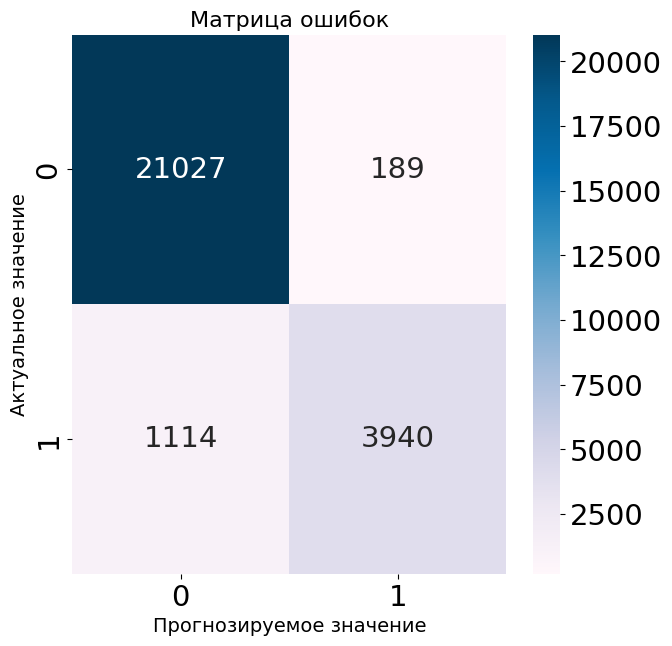

In [53]:
plot_cm(y_test, pred)

In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import math


def plot_roc(y_test,predictions_test):
#   print('рассчитываем ROC AUC')
#   print(predictions_test)
#   print("y_test")
#   print(y_test)
  # рассчитываем ROC AUC
  lr_auc = roc_auc_score(y_test, predictions_test)
  print(': ROC AUC=%.3f' % (lr_auc))
  # рассчитываем roc-кривую
  fpr, tpr, treshold = roc_curve(y_test, predictions_test)
  # t = pd.DataFrame({'fpr':fpr, 'tpr':tpr,'thr':treshold})
  # # t.plot(x='fpr',y='tpr',grid=True,figsize=(7,7),xlim=(0,1.1),ylim=(0,1.1),kind='scatter')
  # print(t.head())
  # t['tpr - fpr'] = t['tpr'] - t['fpr']
  # t['tpr - fpr'].apply(lambda x: '%.2f' % x)
  # t['thr'].apply(lambda x: '%.2f' % x)
  # t.sort_values('tpr - fpr',ascending=False)
  # print(t.head())
  # fig, ax = plt.subplots(figsize=(7,7))
  # ax.scatter(t['fpr'], t['tpr'])
  # for i, txt in enumerate(t['thr']):
  #   ax.annotate(round(txt,2), (t['fpr'][i], t['tpr'][i]))
  # plt.show()

  roc_auc = auc(fpr, tpr)
  # строим график

  # размеры шрифта
  SMALL_SIZE = 10
  MEDIUM_SIZE = 14
  BIGGER_SIZE = 16
  plt.rcParams["figure.figsize"] = (7,7)
  plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
  plt.plot(fpr, tpr, color='darkorange',
          label='ROC кривая (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC-кривая')
  plt.legend(loc="lower right",)
  plt.show()
  precision, recall, thresholds = precision_recall_curve(y_test, predictions_test)
  numerator = 2 * recall * precision
  denom = recall + precision
  f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
  max_f1 = np.max(f1_scores)
  max_f1_thresh = thresholds[np.argmax(f1_scores)]
  print('Best F1-Score: ',max_f1)
  print('Best threshold: ',max_f1_thresh)
  plot_cm(y_test,predictions_test, p=max_f1_thresh)
  # tt = pd.DataFrame({'pr':precision, 'recall':recall})
  # tt['pr - recall'] = abs(tt['pr'] - tt['recall'])
  # tt['pr - recall'].apply(lambda x: '%.2f' % x)
  # tt.sort_values('pr - recall',ascending=False)
  # print(tt.head())
  #create precision recall curve
  fig, ax = plt.subplots()
  ax.plot(recall, precision, color='purple')

  #add axis labels to plot
  ax.set_title('Precision-Recall Curve')
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')

  #display plot
  plt.show() 

: ROC AUC=0.979


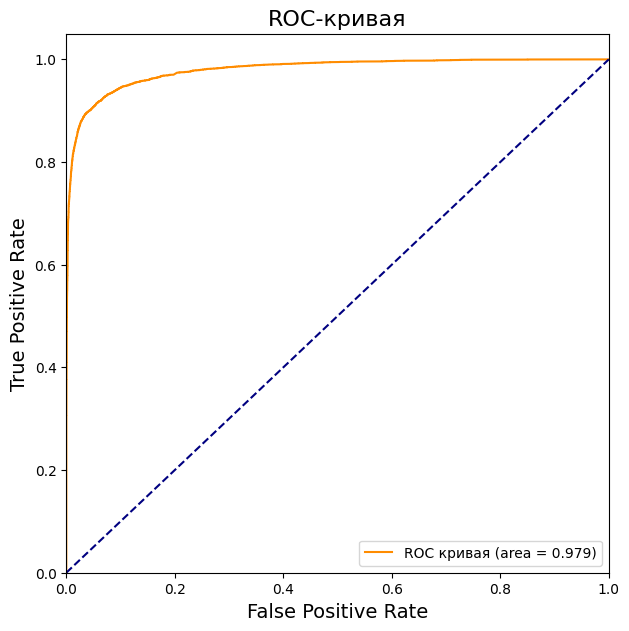

Best F1-Score:  0.8831064044377207
Best threshold:  0.30046586319647667
Accuracy: 95.59 %
Recall: 86.62 %
Precision: 90.06 %
F1-score: 88.31 % 

precision: 0.93453111161695, recall: 0.921739360830631, f1score: 0.9279578943009718
              precision    recall  f1-score   support

           0     0.9684    0.9772    0.9728     21216
           1     0.9006    0.8662    0.8831      5054

    accuracy                         0.9559     26270
   macro avg     0.9345    0.9217    0.9280     26270
weighted avg     0.9554    0.9559    0.9556     26270

True Negatives:  20733
False Positives:  483
False Negatives:  676
True Positives:  4378


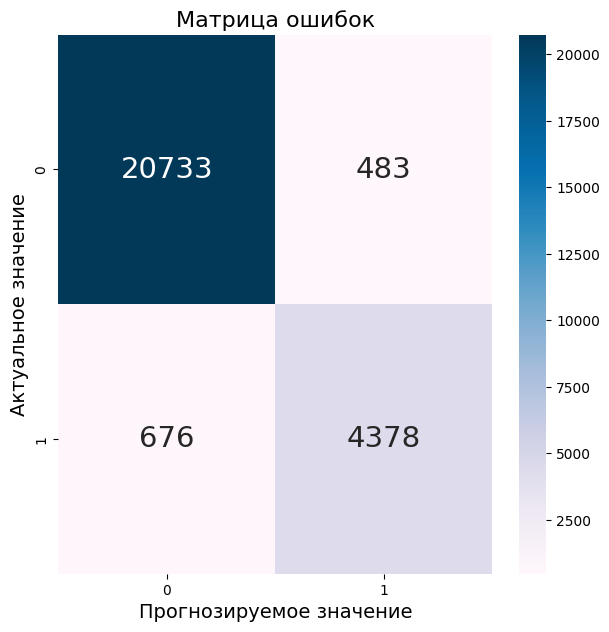

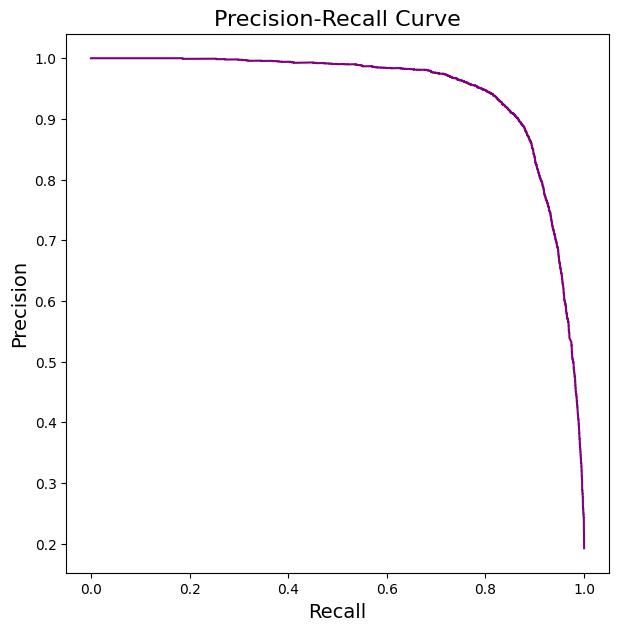

In [60]:
plot_roc(y_test, pred)

#**Отобразим топ нейтральных и токсичных слов в текстах датасета**

In [57]:
def wordplot(txt_toxic, txt_neutral):
    
    txt_toxic=' '.join(txt_toxic)
    txt_neutral=' '.join(txt_neutral)

    fig, axs = plt.subplots(figsize=(20, 12))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    WIDTH=1600
    HEIGHT=1600
    
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Blues',
                          max_words=200,
                          mask=None
                          ).generate(txt_neutral)
    plt.axis('off')

    FONTSIZE=21
    INTERPOLATION='bilinear'

    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('NEUTRAL \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Oranges',
                          max_words=200,
                          mask=None, 
                          ).generate(txt_toxic)
    
    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('TOXIC \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [58]:
feature_to_coef = { word: coef for word, coef in zip(vectorize.get_feature_names_out(), clf.coef_[0]) }

toxic, neutral   = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    toxic.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    neutral.append(best_positive[0])

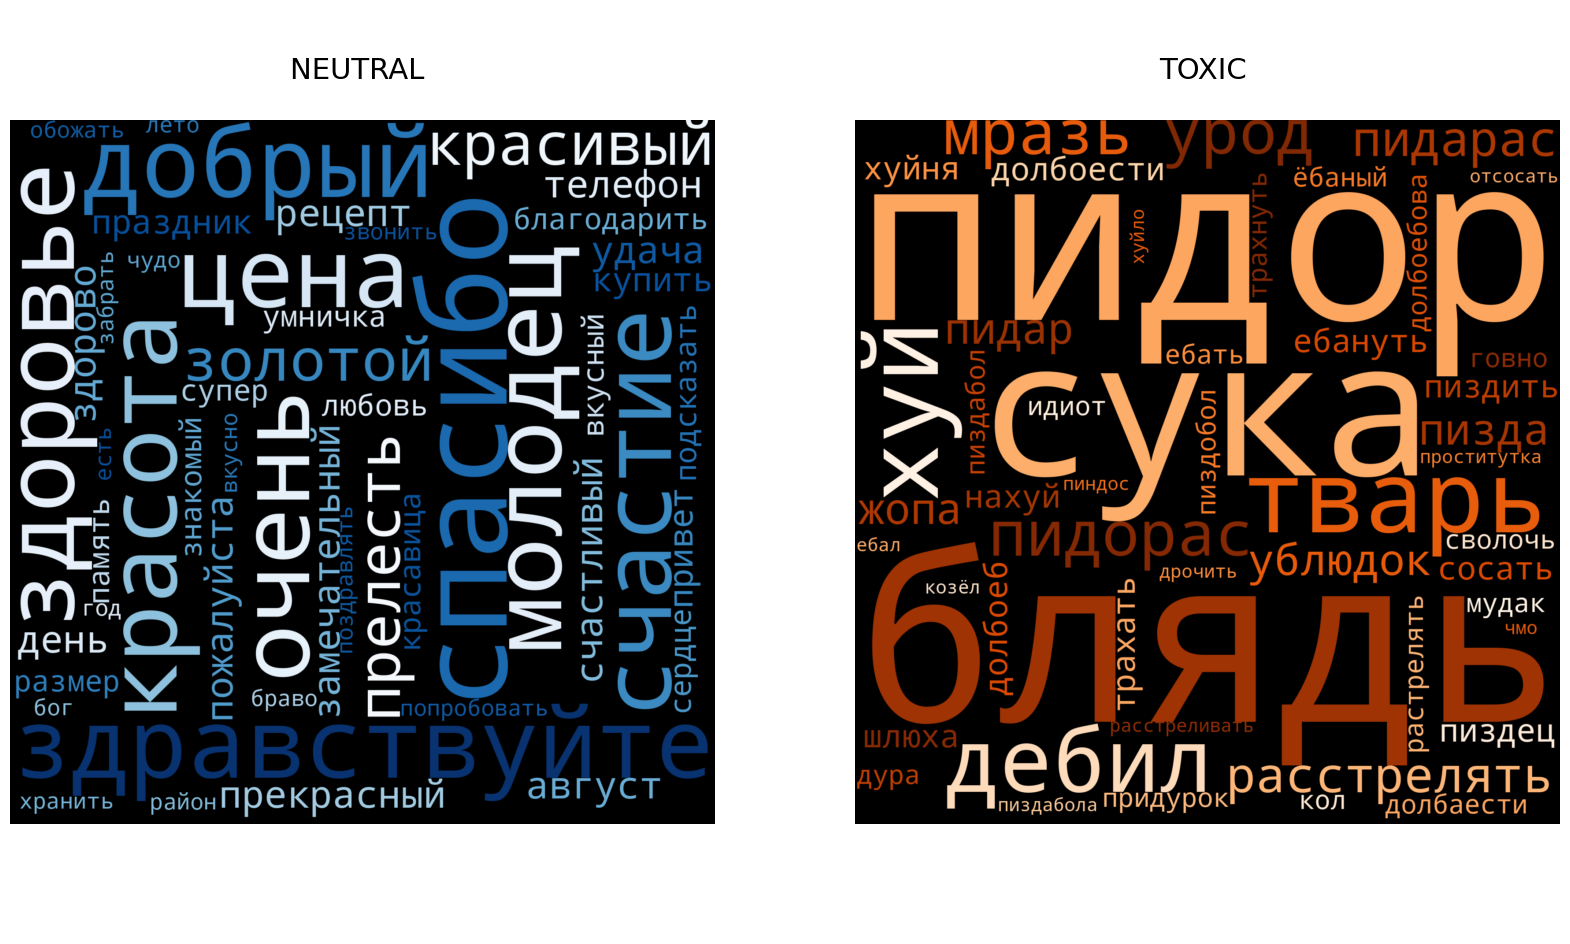

In [59]:
wordplot(toxic, neutral)